In [1]:
# https://github.com/pytorch/examples/blob/master/mnist/main.py
from __future__ import print_function
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import PIL
from random import shuffle
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import random
import pickle

In [2]:
with open('dataconvall.pt', 'rb') as f:
    data = pickle.load(f)
    
with open('labelsall.pt', 'rb') as f:
    labels = pickle.load(f)
    
with open('datavalconvall.pt', 'rb') as f:
    dataVal = pickle.load(f)
    
with open('labelsval.pt', 'rb') as f:
    labelsVal = pickle.load(f)

with open('imglist.pt', 'rb') as f:
    images = pickle.load(f)

In [3]:
class PonceResNet(nn.Module):
    def __init__(self,dropout=0.5):
        super(PonceResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(20, 30, kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(30, 40, kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(40, 50, kernel_size=3,padding=1)
        self.ds1 = nn.Conv2d(3,30,kernel_size=1)
        self.ds2 = nn.Conv2d(30,50,kernel_size=1)
        self.mp = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(20)
        self.bn2 = nn.BatchNorm2d(30)
        self.bn3 = nn.BatchNorm2d(40)
        self.bn4 = nn.BatchNorm2d(50)
        self.fc1 = nn.Linear(50400,200)
        self.fc2 = nn.Linear(200, 4)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        in_size = x.size(0)
        x = self.mp(x)
        x = self.mp(x)
        y = x
        x = self.dropout(torch.relu(self.bn1(self.conv1(x))))
        x = self.dropout((self.bn2(self.conv2(x))))
        y = self.ds1(y)
        x += y
        x = torch.relu(x)
        x = self.mp(x)
        y = x
        x = self.dropout(torch.relu(self.bn3(self.conv3(x))))
        x = self.dropout(self.bn4(self.conv4(x)))
        y = self.ds2(y)
        x += y
        x = torch.relu(x)
        x = self.mp(x)
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return torch.log_softmax(x,1)


In [4]:
class AutoUXDataset(Dataset):
    def __init__(self, data, labels,isTrain=True,isVal=False):
        self.data = data
        self.labels = labels
        self.isTrain = isTrain
        self.isVal = isVal
        if isVal:
            self.testX = torch.from_numpy(np.asarray(data,dtype=np.uint8)).type('torch.FloatTensor')
            self.testY = torch.from_numpy(np.asarray(labels,dtype=np.uint8)).type('torch.LongTensor')
        else:
            self.setTest(0)

    def __len__(self):
        if self.isTrain:
            return len(self.trainX)
        else:
            return len(self.testX)

    def setTest(self,testI):
        if self.isVal:
            d = self.data
            l = self.labels
            self.testX = torch.from_numpy(np.asarray(d,dtype=np.uint8)).type('torch.FloatTensor')
            self.testY = torch.from_numpy(np.asarray(l,dtype=np.uint8)).type('torch.LongTensor')
            return
        d = np.empty((0,3,384,683),int)
        l = []
        for i in range(5):
            if i != testI:
                d = np.append(d,self.data[i],axis=0)
                l += self.labels[i]
            else:
                self.testX = torch.from_numpy(np.asarray(data[i],dtype=np.uint8)).type('torch.FloatTensor')
                self.testY = torch.from_numpy(np.asarray(labels[i],dtype=np.uint8)).type('torch.LongTensor')
                
        self.trainX = torch.from_numpy(np.asarray(d,dtype=np.uint8)).type('torch.FloatTensor')
        self.trainY = torch.from_numpy(np.asarray(l,dtype=np.uint8)).type('torch.LongTensor')
    
    def __getitem__(self, idx):
        if self.isTrain:
            return {"img" : self.trainX[idx], "label": self.trainY[idx]}
        else:
            return {"img" : self.testX[idx], "label": self.testY[idx]}

In [5]:
def train_batch(model,crit,opt,x, y):
    opt.zero_grad()
    y_pred = model(x)
    loss = crit(y_pred, y)
    loss.backward()
    opt.step() 
    return loss.item(),torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

def train(model,crit,opt,dataload,disable=False):
    # Training loop
    dloss, dacc = 0,0
    for s in tqdm(dataload,disable=disable):
        x, y = s.values()
        x = x.cuda()
        y = y.cuda()
        lo, acc = train_batch(model,crit,opt,x,y)
        dloss += lo
        dacc += acc
    dloss /= len(dataload)
    dacc /= len(dataload)
    return dloss,dacc

def test_batch(model,crit,x, y):
    y_pred = model(x)
    loss = crit(y_pred, y)
    return loss.item(),torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

def test(model,crit,dataload,disable=False):
    # Training loop
    dloss, dacc = 0,0
    with torch.no_grad():
        for s in tqdm(dataload,disable=disable):
            x, y = s.values()
            x = x.cuda()
            y = y.cuda()
            lo, acc = test_batch(model,crit,x,y)
            dloss += lo
            dacc += acc
    dloss /= len(dataload)
    dacc /= len(dataload)
    return dloss,dacc

Fold 1
Epoch Train Loss: 2.088498  Epoch Train Accuracy: 51.791188  Epoch Test Loss: 1.098132  Epoch Test Accuracy: 50.252525
Epoch Train Loss: 0.210972  Epoch Train Accuracy: 91.757663  Epoch Test Loss: 0.855187  Epoch Test Accuracy: 57.020202
Epoch Train Loss: 0.101799  Epoch Train Accuracy: 99.161877  Epoch Test Loss: 0.976292  Epoch Test Accuracy: 53.333333
Epoch Train Loss: 0.084840  Epoch Train Accuracy: 99.157088  Epoch Test Loss: 0.999552  Epoch Test Accuracy: 53.282828
Epoch Train Loss: 0.076375  Epoch Train Accuracy: 99.300766  Epoch Test Loss: 1.014016  Epoch Test Accuracy: 51.717172
Epoch Train Loss: 0.079130  Epoch Train Accuracy: 98.745211  Epoch Test Loss: 1.068483  Epoch Test Accuracy: 49.242424
Epoch Train Loss: 0.071634  Epoch Train Accuracy: 99.578544  Epoch Test Loss: 1.005338  Epoch Test Accuracy: 53.131313
Epoch Train Loss: 0.100254  Epoch Train Accuracy: 97.887931  Epoch Test Loss: 1.060220  Epoch Test Accuracy: 52.626263
Epoch Train Loss: 0.071773  Epoch Train A

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Fold 2
Epoch Train Loss: 3.901260  Epoch Train Accuracy: 47.755634  Epoch Test Loss: 3.236066  Epoch Test Accuracy: 34.745763
Epoch Train Loss: 0.349536  Epoch Train Accuracy: 85.863289  Epoch Test Loss: 1.889787  Epoch Test Accuracy: 39.830508
Epoch Train Loss: 0.241294  Epoch Train Accuracy: 90.109890  Epoch Test Loss: 0.953322  Epoch Test Accuracy: 41.525424
Epoch Train Loss: 0.219315  Epoch Train Accuracy: 92.903706  Epoch Test Loss: 1.112367  Epoch Test Accuracy: 40.677966
Epoch Train Loss: 0.237752  Epoch Train Accuracy: 91.469547  Epoch Test Loss: 1.990902  Epoch Test Accuracy: 40.254237
Epoch Train Loss: 0.155476  Epoch Train Accuracy: 96.945427  Epoch Test Loss: 0.877906  Epoch Test Accuracy: 61.864407
Epoch Train Loss: 0.272362  Epoch Train Accuracy: 89.569752  Epoch Test Loss: 1.191322  Epoch Test Accuracy: 40.254237
Epoch Train Loss: 0.204806  Epoch Train Accuracy: 93.611473  Epoch Test Loss: 0.931488  Epoch Test Accuracy: 65.254237
Epoch Train Loss: 0.202158  Epoch Train A

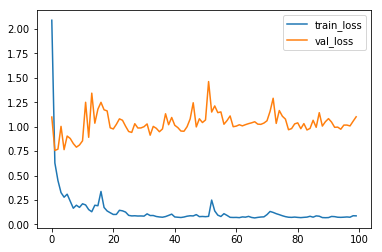

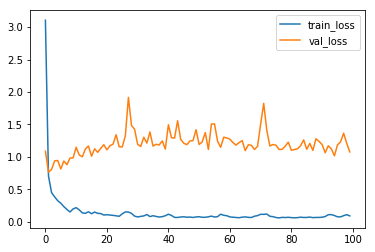

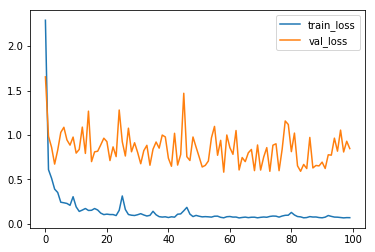

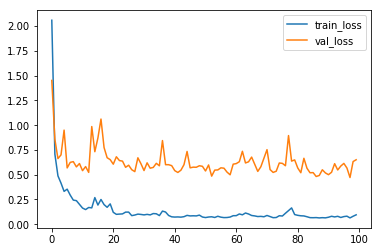

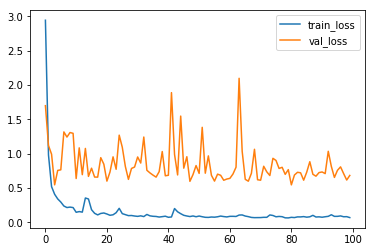

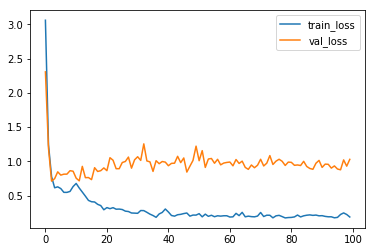

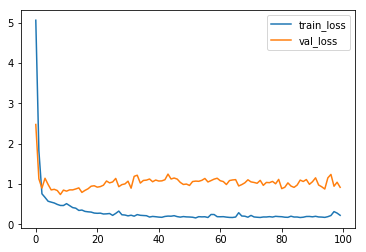

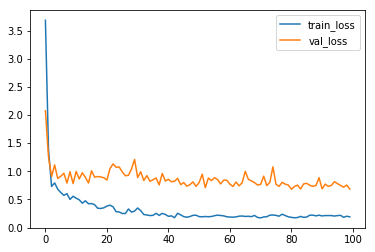

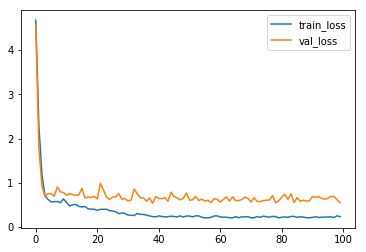

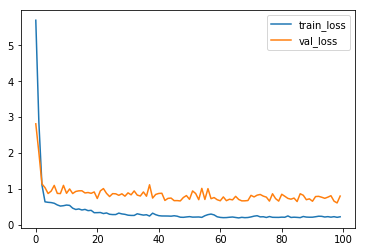

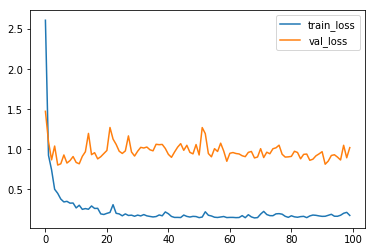

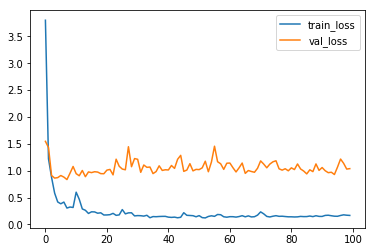

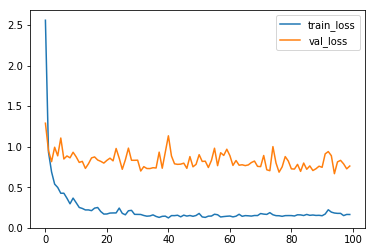

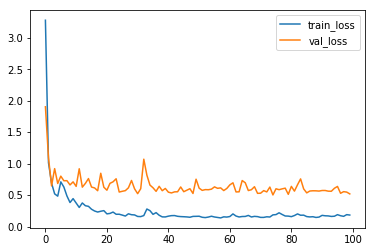

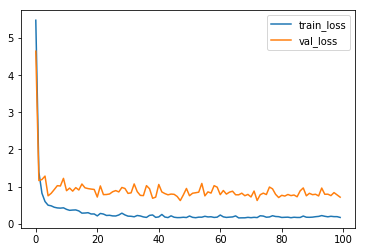

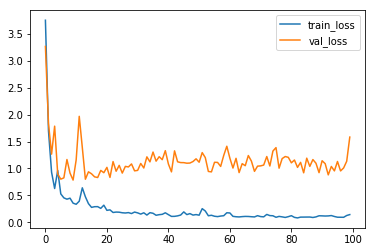

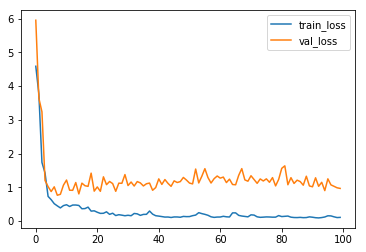

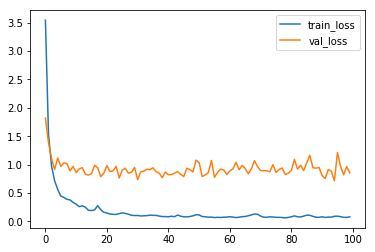

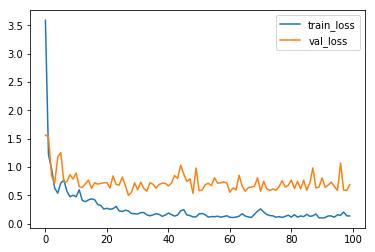

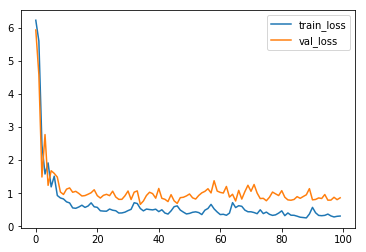

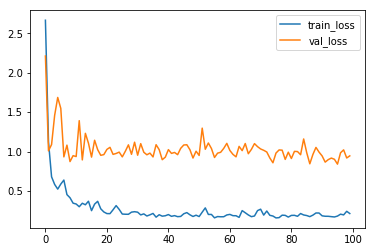

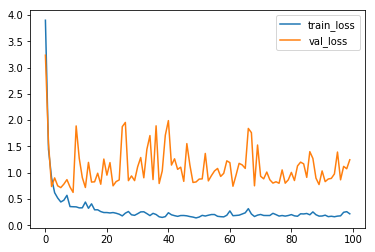

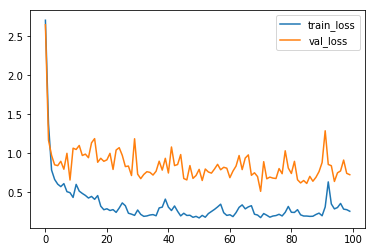

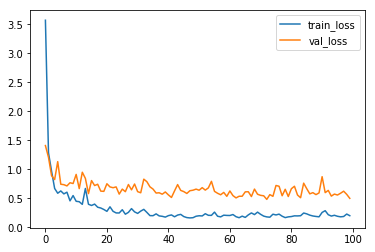

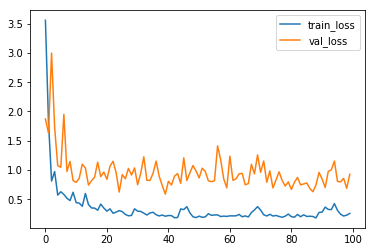

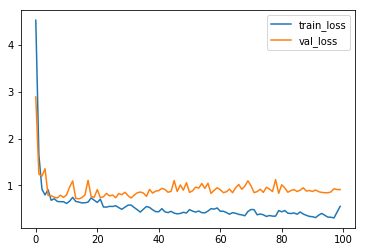

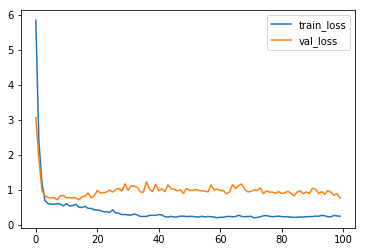

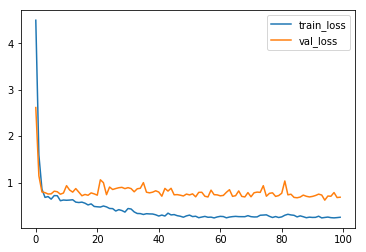

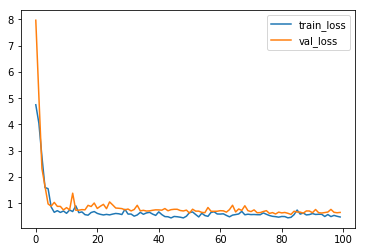

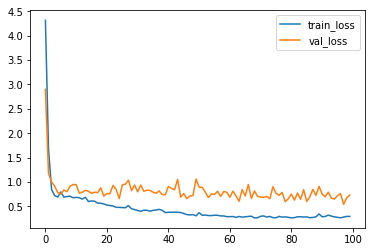

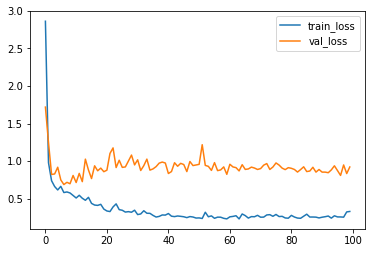

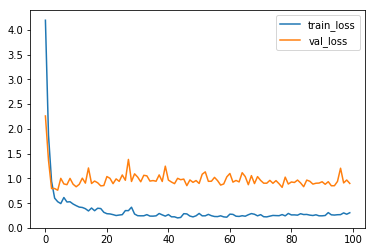

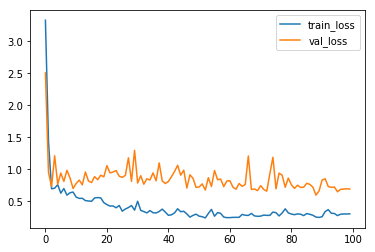

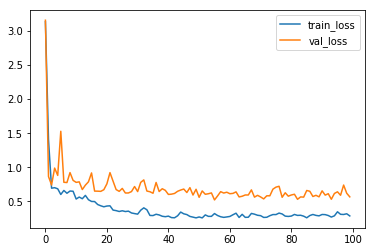

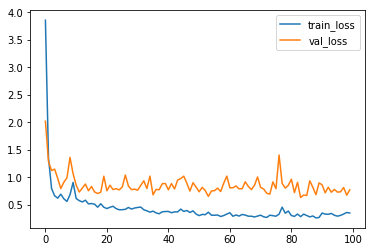

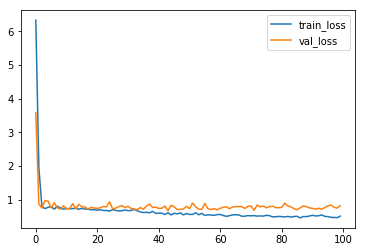

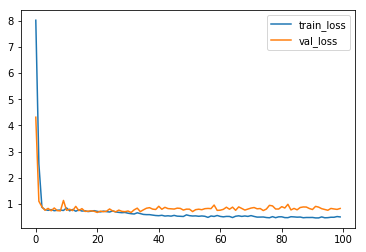

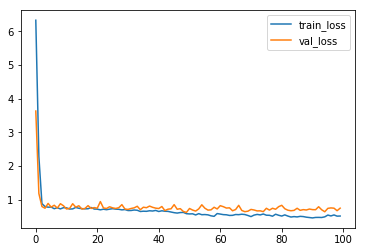

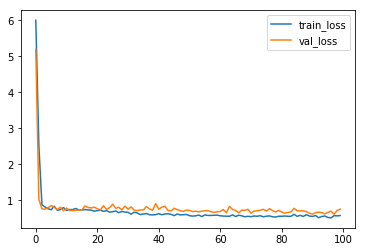

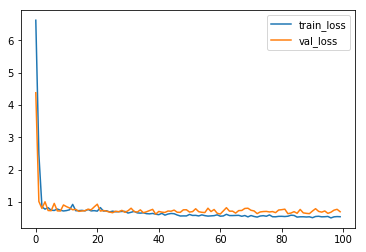

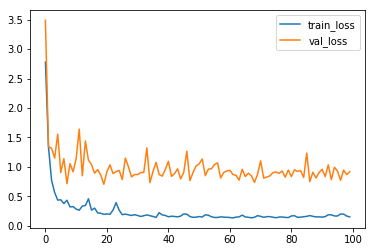

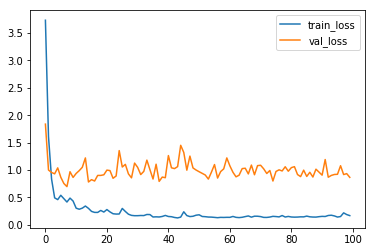

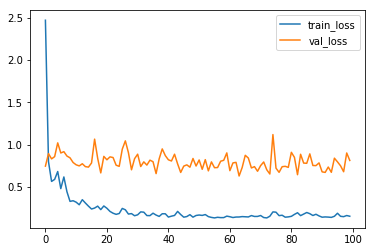

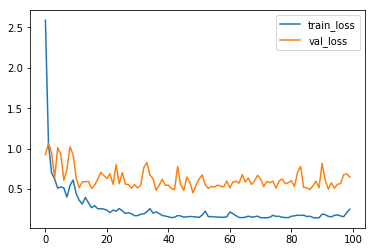

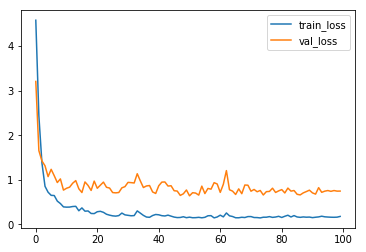

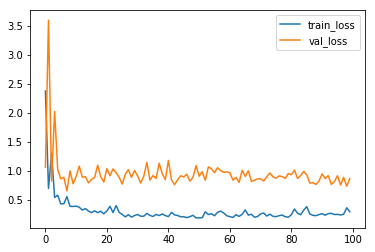

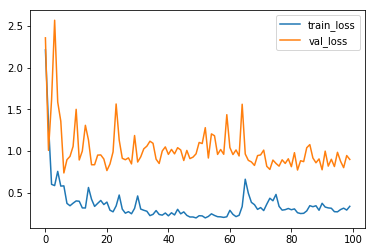

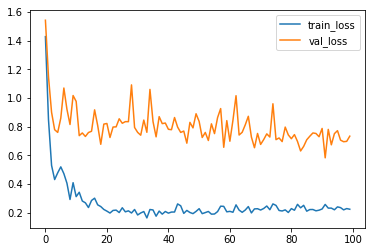

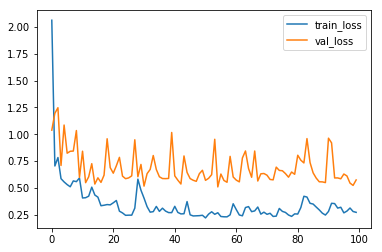

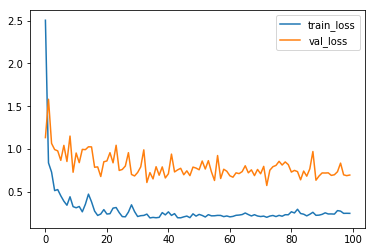

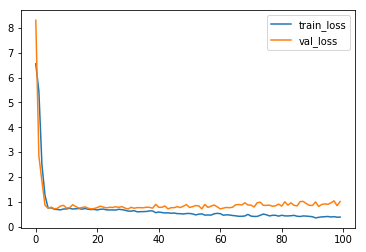

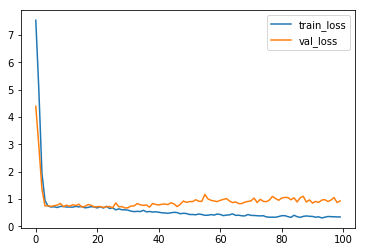

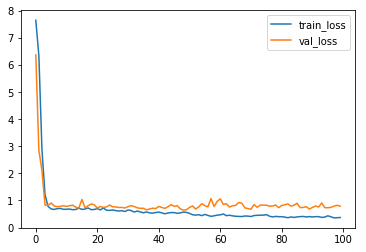

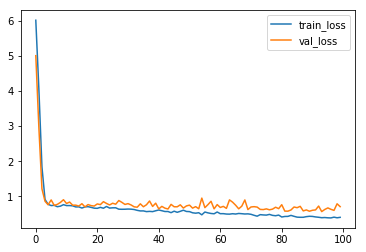

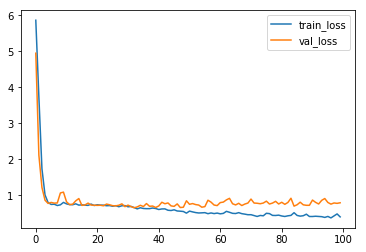

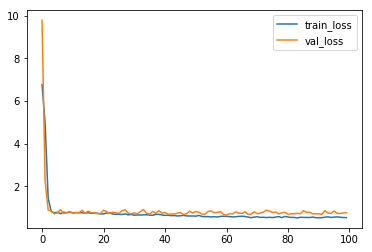

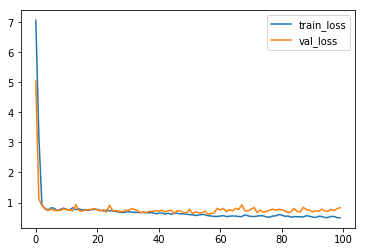

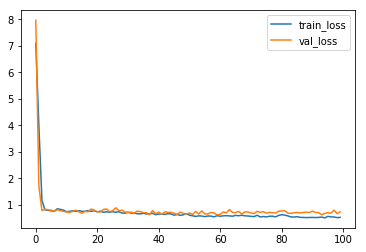

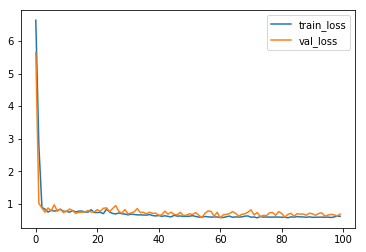

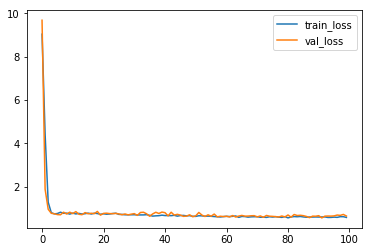

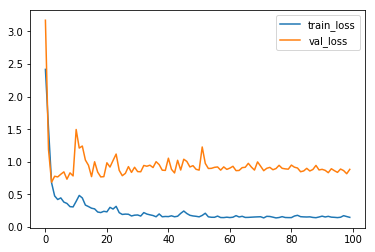

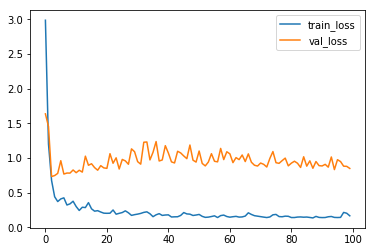

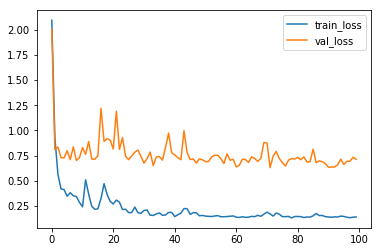

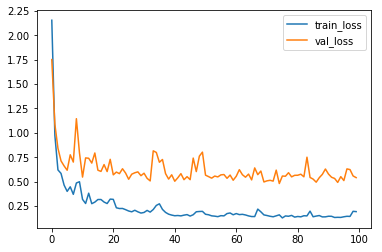

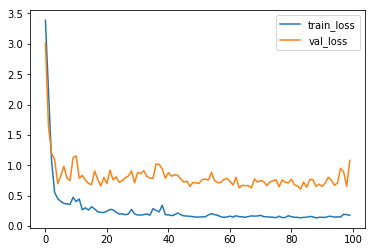

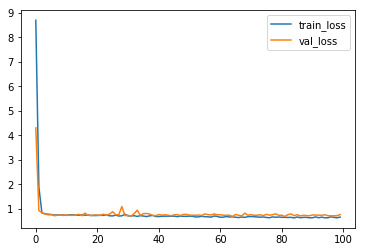

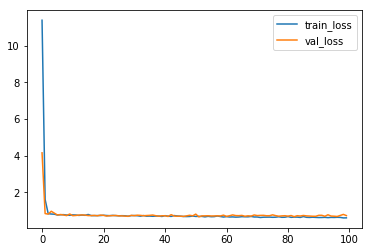

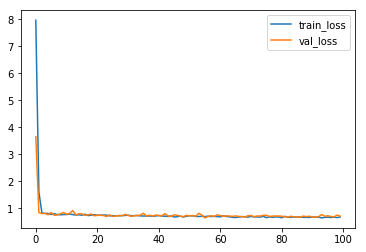

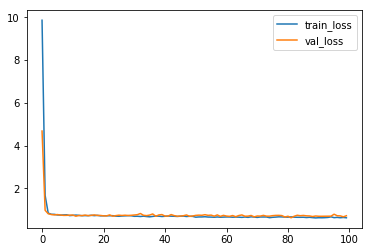

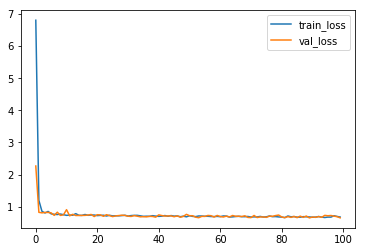

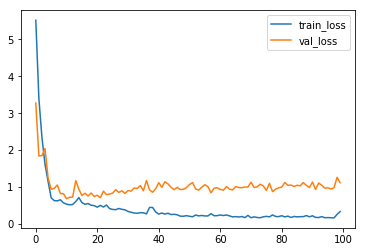

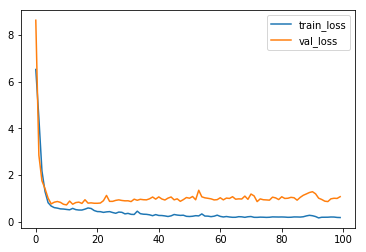

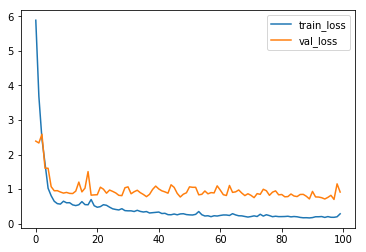

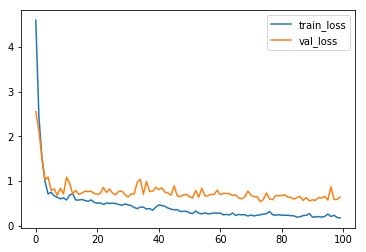

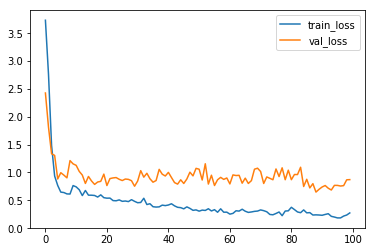

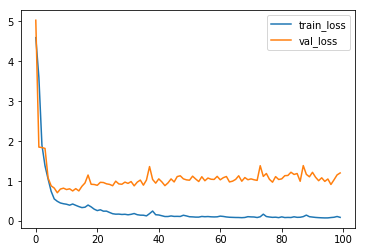

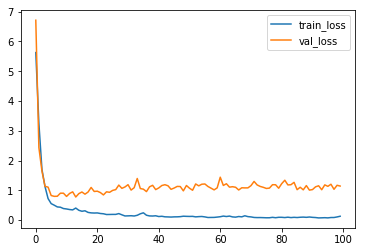

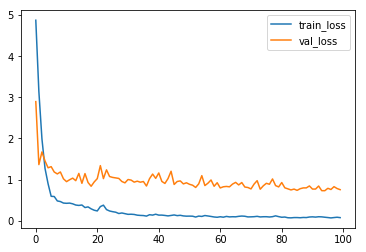

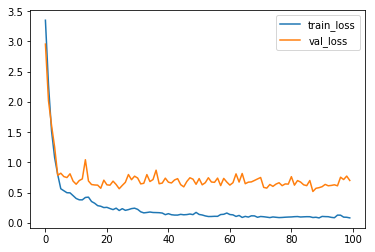

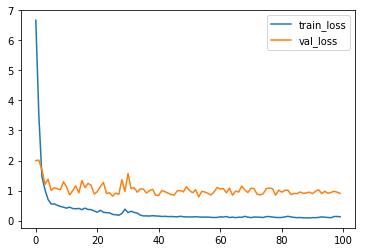

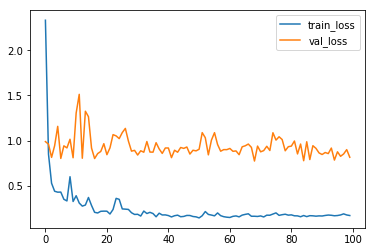

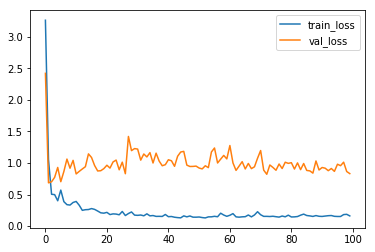

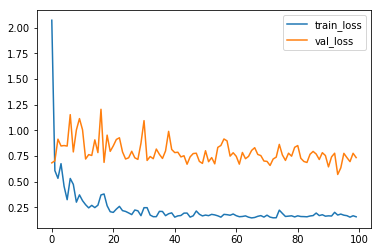

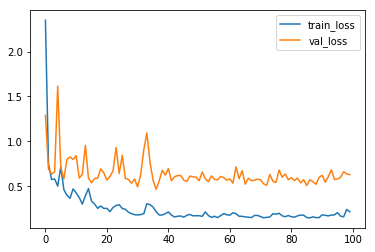

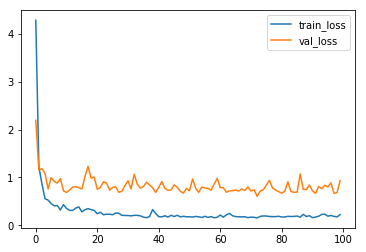

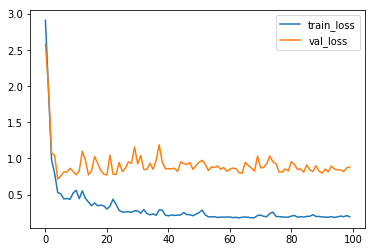

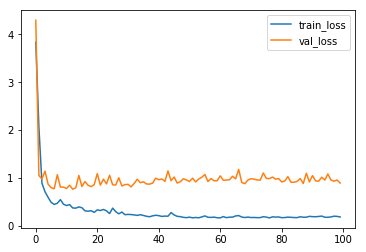

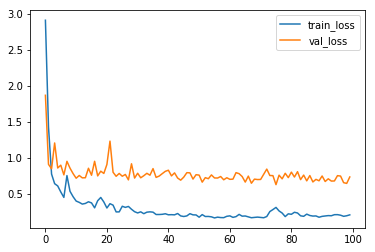

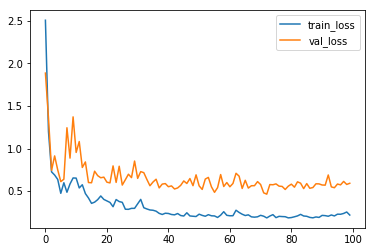

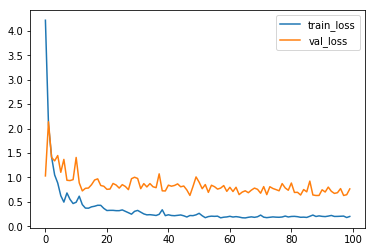

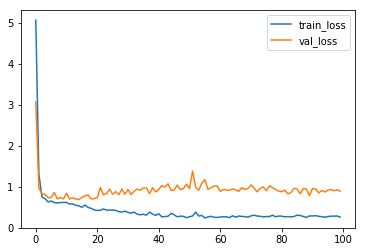

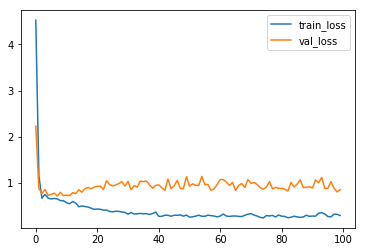

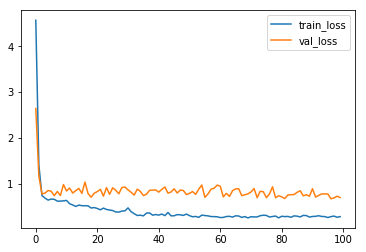

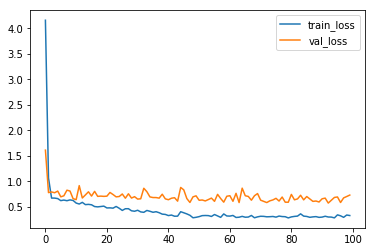

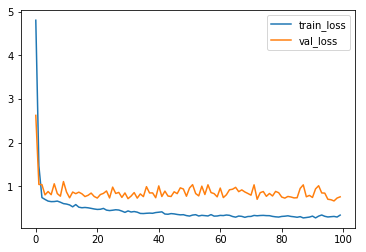

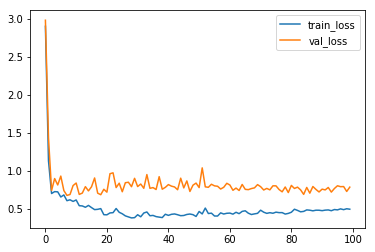

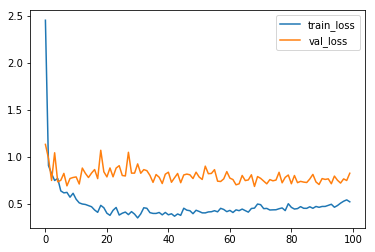

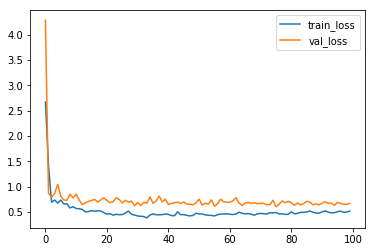

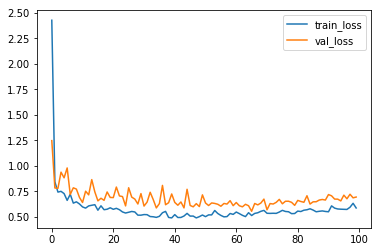

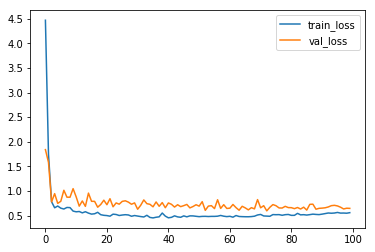

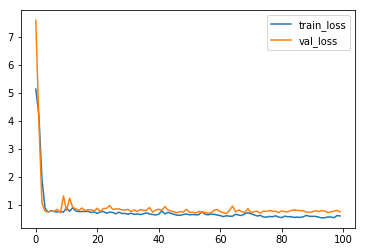

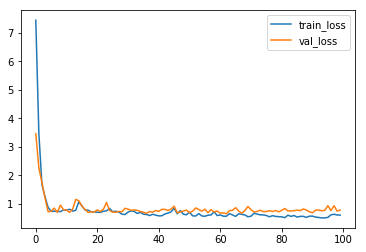

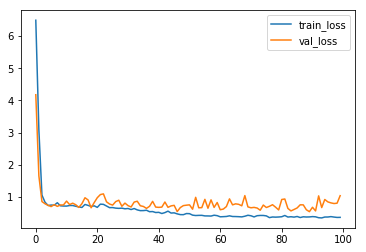

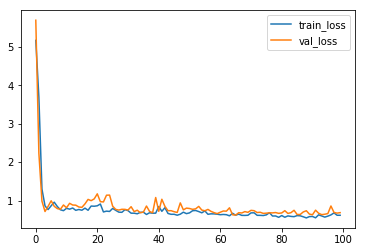

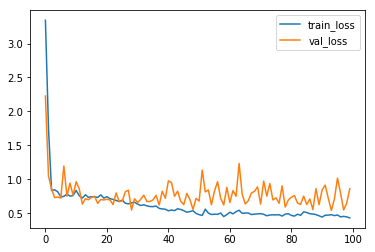

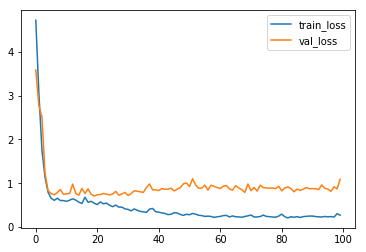

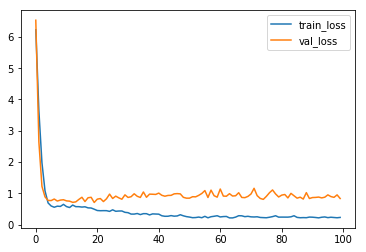

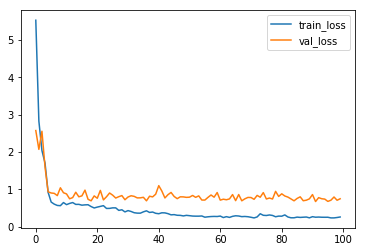

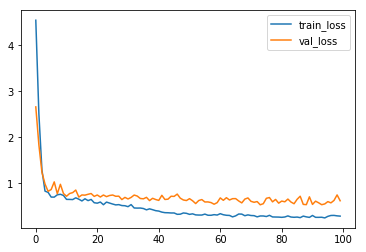

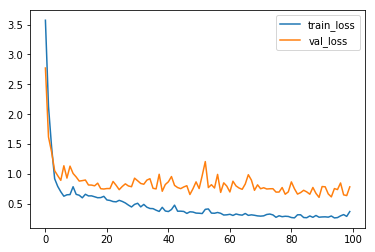

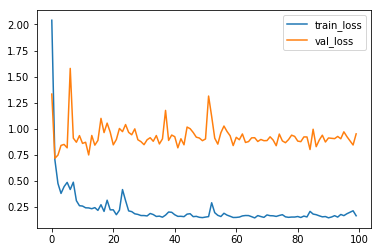

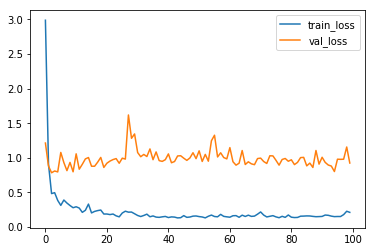

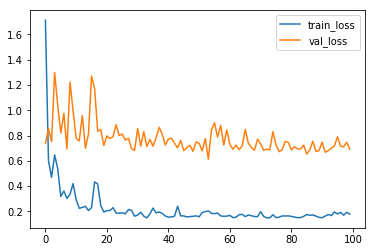

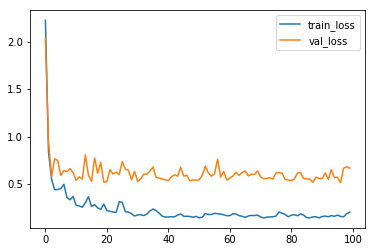

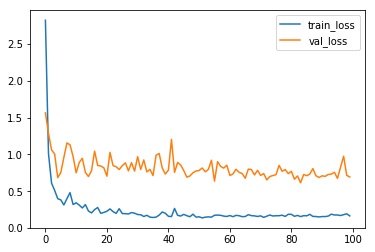

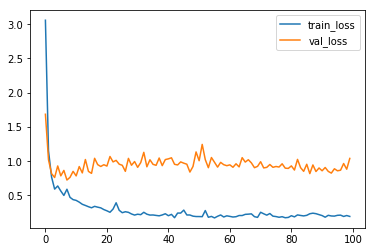

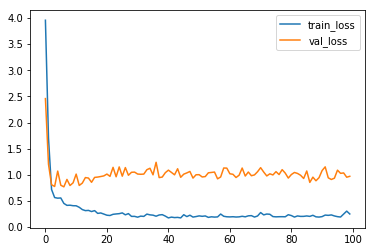

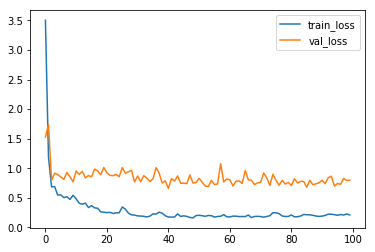

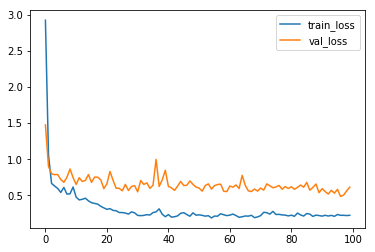

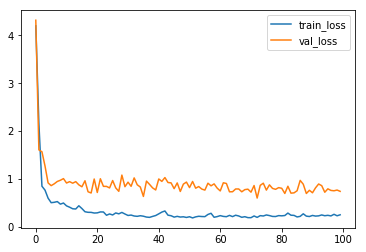

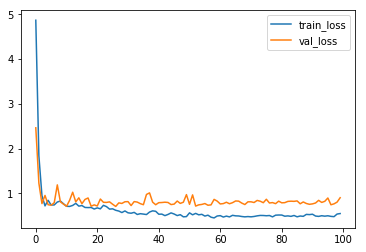

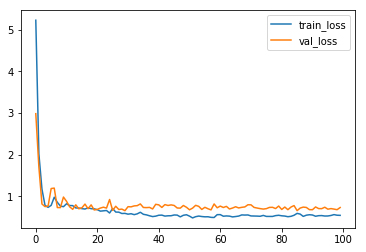

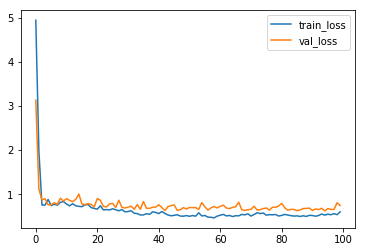

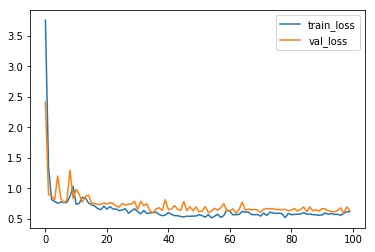

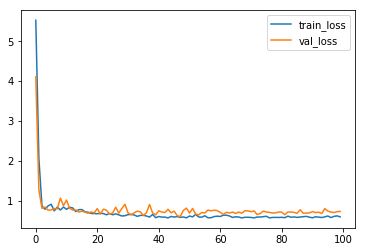

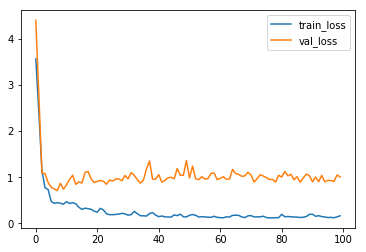

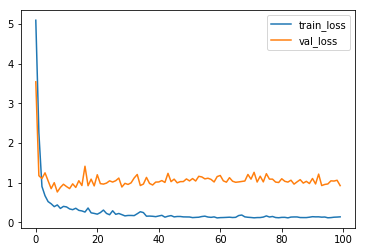

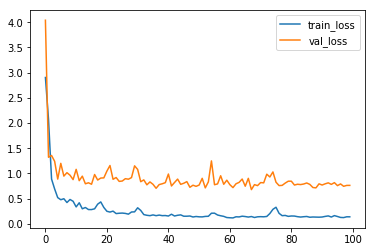

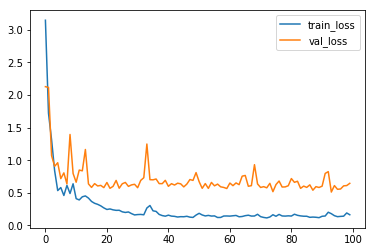

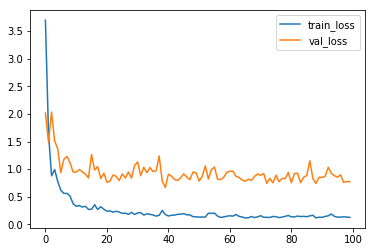

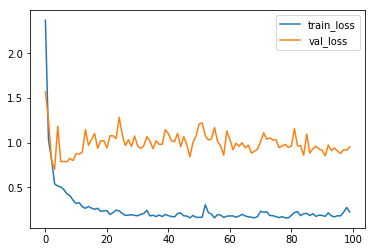

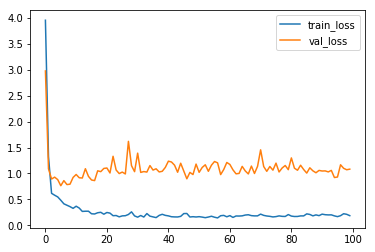

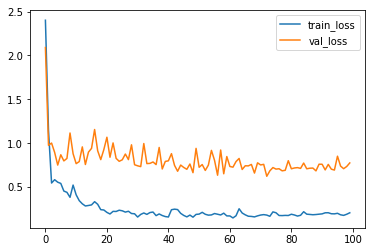

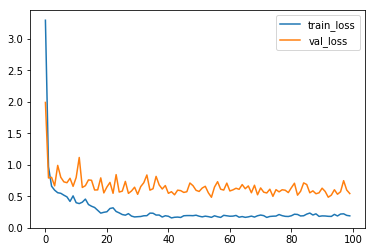

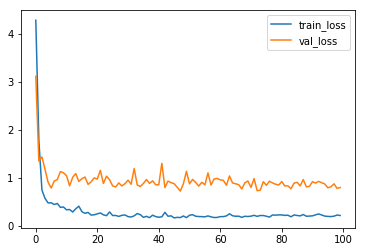

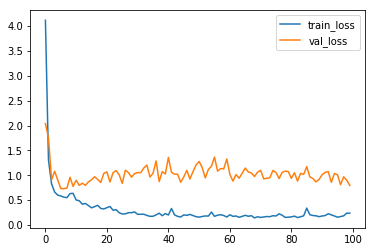

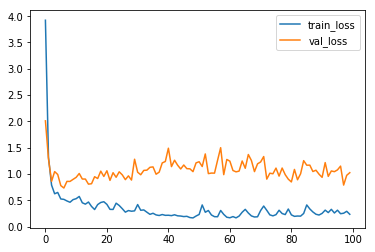

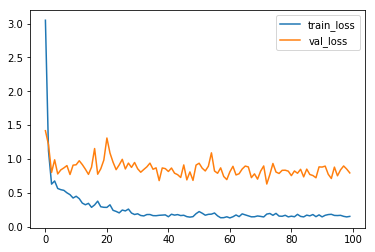

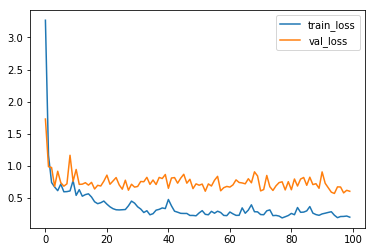

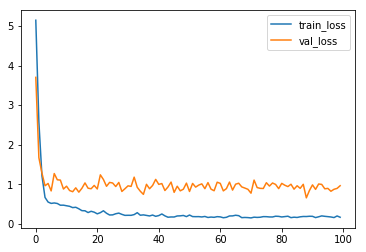

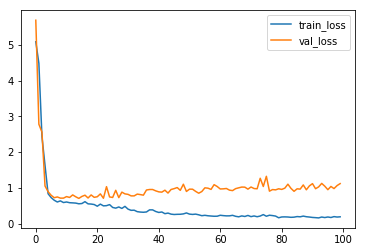

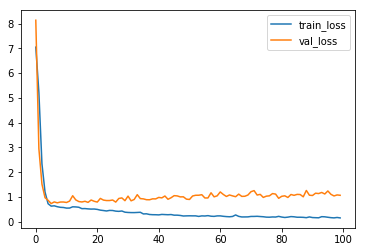

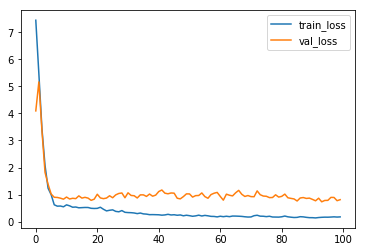

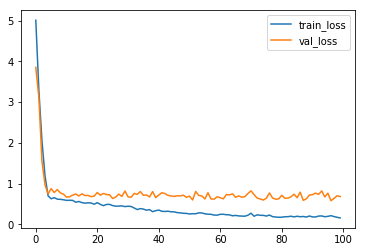

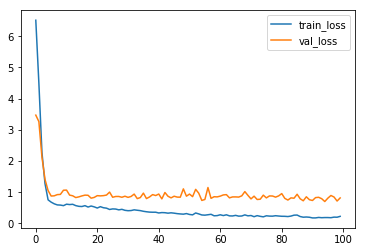

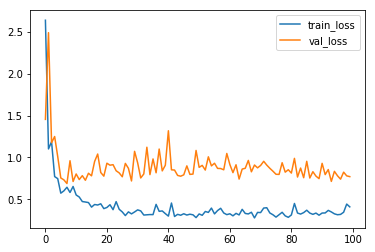

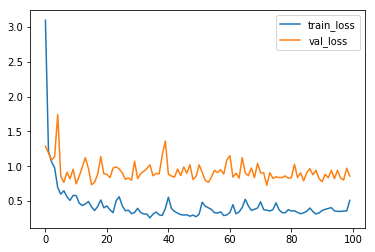

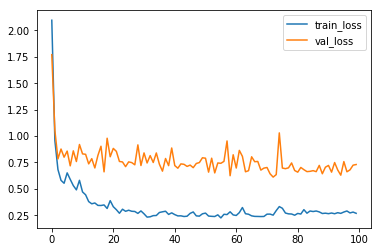

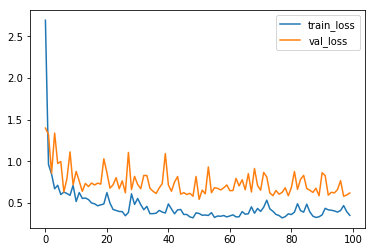

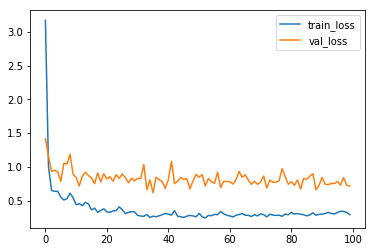

In [6]:
my_data = AutoUXDataset(data,labels,True)
my_test = AutoUXDataset(data,labels,False)

num_attempts = 30

random.seed(4815162352)
batch_sizes = [int(np.round(2 ** random.uniform(5,7))) for i in range(num_attempts)]
hidden_dims = [int(np.round(2 ** random.normalvariate(7.5,0.562519722))) for i in range(num_attempts)]
dropouts = [random.uniform(0,0.9) for i in range(num_attempts)]
weight_decays = [np.exp(random.normalvariate(0,0.5)) for i in range(num_attempts)]
stats = []
fbs,fwd,fhd,fd = 0,0,0,0
best_acc = -999

disable = True
epochs = 100
every_other = 10

for i in range(len(batch_sizes)):
    avedloss, avedacc, avevloss, avevacc = 0,0,0,0
    batch_size = batch_sizes[i]
    weight_decay = weight_decays[i]
    hidden_dim = hidden_dims[i]
    dropout = dropouts[i]
    for i in range(5):
        torch.manual_seed(4815162342)
        model = PonceResNet(dropout=dropout).cuda()
        optimizer = optim.Adam(model.parameters(), lr=3e-4,weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()
        dlosscurve = []
        dacccurve = []
        vlosscurve = []
        vacccurve = []
        print("Fold %d" % (i + 1))
        my_data.setTest(i)
        my_test.setTest(i)

        my_loader = DataLoader(my_data, batch_size=batch_size,
                                shuffle=True)
        my_test_loader = DataLoader(my_test, batch_size=batch_size,
                                shuffle=True)
        for j in range(epochs):
            dloss, dacc = train(model,criterion,optimizer,my_loader,disable)
            vloss, vacc = test(model,criterion,my_test_loader,disable)
            dlosscurve.append(dloss)
            dacccurve.append(dacc)
            vlosscurve.append(vloss)
            vacccurve.append(vacc)
            if j % every_other == 0:
                print("Epoch Train Loss: {:.6f}  Epoch Train Accuracy: {:.6f}  Epoch Test Loss: {:.6f}  Epoch Test Accuracy: {:.6f}".format(dloss,dacc * 100,vloss,vacc * 100))
        df = pd.DataFrame(data={"train_loss": dlosscurve, "val_loss": vlosscurve})
        df.plot.line()
        avedloss += dloss
        avedacc += dacc
        avevloss += vloss
        avevacc += vacc
    avedloss /= 5
    avedacc /= 0.05
    avevloss /= 5
    avevacc /= 0.05
    if avevacc > best_acc:
        fbs,fwd,fhd,fd,best_acc = batch_size, weight_decay, hidden_dim, dropout, avevacc
    print("Batch Size: {}\nWeight Decay: {}\nHidden Dimensions: {}\nDropout: {}\n".format(batch_size,weight_decay,hidden_dim,dropout))
    print("Average Train Loss: {:.6f}\nAverage Train Accuracy: {:.6f}\nAverage Test Loss: {:.6f}\nAverage Test Accuracy: {:.6f}\n".format(avedloss,avedacc,avevloss,avevacc))
    stats.append([avedloss,avedacc,avevloss,avevacc])

In [7]:
for i in range(len(stats)):
    print("{:.2f} & {:.2f} & {:.2f} & {:.2f} & {} \\\\ \\hline".format(batch_sizes[i],weight_decays[i],hidden_dims[i],dropouts[i]," & ".join(["{:.2f}{}".format(stats[i][j],"\\%" if j % 2 == 1 else "") for j in range(len(stats[i]))])))

# hyperparameters
batch_size = fbs
weight_decay = fwd
hidden_dim = fhd
dropout = fd
disable = False
epochs = 50
every_other = 10

# initializing training objects
torch.manual_seed(4815162342)
model = PonceResNet(dropout=dropout).cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-4,weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# initializing dataset
my_data = AutoUXDataset(data,labels,True)
my_val = AutoUXDataset(dataVal,labelsVal,False,True)
my_loader = DataLoader(my_data, batch_size=batch_size,shuffle=True)
my_val_loader = DataLoader(my_val, batch_size=batch_size,shuffle=True)
my_data.setTest(-1)
my_val.setTest(-1)

# initializing tracking variables
dlosscurve = []
dacccurve = []
vlosscurve = []
vacccurve = []

# training loop
for j in range(epochs):
    dloss, dacc = train(model,criterion,optimizer,my_loader,disable)
    vloss, vacc = test(model,criterion,my_val_loader,disable)
    dlosscurve.append(dloss)
    dacccurve.append(dacc)
    vlosscurve.append(vloss)
    vacccurve.append(vacc)
    if j % every_other == 0:
        print("Epoch Train Loss: {:.6f}  Epoch Train Accuracy: {:.6f}  Epoch Test Loss: {:.6f}  Epoch Test Accuracy: {:.6f}".format(dloss,dacc * 100,vloss,vacc * 100))

print("Batch Size: {}\nWeight Decay: {}\nHidden Dimensions: {}\nDropout: {}\n".format(batch_size,weight_decay,hidden_dim,dropout))
print("Train Loss: {:.6f}\nTrain Accuracy: {:.6f}\nValidation Loss: {:.6f}\nValidation Accuracy: {:.6f}\n".format(dloss,dacc * 100,vloss,vacc * 100))
print("{} & {:.2f} & {} & {:.2f} & {:.2f} & {:.2f}\% & {:.2f} & {:.2f}\% \\\\ \\hline".format(batch_size,weight_decay,hidden_dim,dropout,dloss,dacc * 100,vloss, vacc * 100))

60.00 & 0.47 & 104.00 & 0.02 & 0.08 & 99.11\% & 0.87 & 61.58\% \\ \hline
61.00 & 0.79 & 164.00 & 0.37 & 0.21 & 93.98\% & 0.80 & 60.92\% \\ \hline
62.00 & 0.87 & 209.00 & 0.14 & 0.17 & 96.83\% & 0.81 & 61.17\% \\ \hline
79.00 & 0.42 & 180.00 & 0.20 & 0.16 & 96.43\% & 0.99 & 58.69\% \\ \hline
59.00 & 0.79 & 134.00 & 0.21 & 0.23 & 94.01\% & 0.87 & 58.64\% \\ \hline
65.00 & 1.07 & 138.00 & 0.45 & 0.37 & 84.48\% & 0.75 & 62.49\% \\ \hline
47.00 & 0.90 & 351.00 & 0.35 & 0.32 & 88.52\% & 0.77 & 61.41\% \\ \hline
70.00 & 1.06 & 178.00 & 0.72 & 0.53 & 74.48\% & 0.77 & 58.80\% \\ \hline
83.00 & 1.10 & 163.00 & 0.08 & 0.18 & 95.62\% & 0.80 & 56.67\% \\ \hline
42.00 & 1.00 & 197.00 & 0.09 & 0.28 & 92.47\% & 0.75 & 62.36\% \\ \hline
99.00 & 0.83 & 165.00 & 0.67 & 0.38 & 84.73\% & 0.85 & 60.31\% \\ \hline
81.00 & 2.10 & 152.00 & 0.71 & 0.55 & 73.68\% & 0.73 & 59.83\% \\ \hline
94.00 & 1.34 & 150.00 & 0.01 & 0.16 & 97.22\% & 0.81 & 60.92\% \\ \hline
50.00 & 0.78 & 225.00 & 0.84 & 0.65 & 62.72\% & 0.7

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


Epoch Train Loss: 5.180835  Epoch Train Accuracy: 47.417582  Epoch Test Loss: 2.272821  Epoch Test Accuracy: 44.444444


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


Epoch Train Loss: 0.571282  Epoch Train Accuracy: 70.437271  Epoch Test Loss: 0.667444  Epoch Test Accuracy: 66.666667


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.09it/s]


Epoch Train Loss: 0.517682  Epoch Train Accuracy: 74.581044  Epoch Test Loss: 0.676584  Epoch Test Accuracy: 62.222222


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.48it/s]


Epoch Train Loss: 0.420575  Epoch Train Accuracy: 83.573718  Epoch Test Loss: 0.611427  Epoch Test Accuracy: 71.111111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.79it/s]


Epoch Train Loss: 0.384094  Epoch Train Accuracy: 83.056319  Epoch Test Loss: 0.485934  Epoch Test Accuracy: 75.555556


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.74it/s]


Batch Size: 65
Weight Decay: 1.0660494533472331
Hidden Dimensions: 138
Dropout: 0.44730539216950743

Train Loss: 0.327378
Train Accuracy: 88.440934
Validation Loss: 0.493399
Validation Accuracy: 77.777778

65 & 1.07 & 138 & 0.45 & 0.33\% & 88.44 & 0.49\% \\ \hline


In [8]:

print("{} & {:.2f} & {} & {:.2f} & {:.2f} & {:.2f}\% & {:.2f} & {:.2f}\% \\\\ \\hline".format(batch_size,weight_decay,hidden_dim,dropout,dloss,dacc * 100,vloss, vacc * 100))


65 & 1.07 & 138 & 0.45 & 0.33 & 88.44\% & 0.49 & 77.78\% \\ \hline


In [ ]:
answers = np.array([])
preds = np.array([])
with torch.no_grad():
    for s in tqdm(my_val,disable=disable):
        x, y = s.values()
        x = x.cuda()
        y = y.cuda()
        y_pred = model(x).cpu()
        answers = np.append(answers,y_pred[:,1])
        preds = np.append(preds,torch.max(y_pred,1)[1])
answers = np.exp(answers)
print(answers)
print(preds)

In [ ]:
false_pos = []
false_neg = []

for i in range(0,len(answers)):
#     print("{} Predicted: {} \t Actual: {}".format(images[i],int(preds[i]),int(labels[i])))
    if int(labels[i]) < int(preds[i]):
        false_pos.append(images[i])
    elif int(labels[i]) > int(preds[i]):
        false_neg.append(images[i])
print("False Positives:")
for x in false_pos:
    print(x)
print("\nFalse Negatives:")
for x in false_neg:
    print(x)

In [ ]:
with open('PonceResNetoutprobs.pt', 'wb') as f:
    pickle.dump(answers, f)

In [ ]:
from sklearn.metrics import *
import itertools
import pickle
with open('PonceResNetout.pt', 'rb') as f:
    y_pred = pickle.load(f)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


y_test = np.array([])

for x in labels:
    y_test = np.append(y_test,x)

class_names = ["bad site","good site"]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
print("Accuracy: {:.4f}".format(np.mean(y_test==y_pred)))